<ipython-input-5-49b14f63f5eb>:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  candlestick_data[f'{col}_lag_{i}'] = candlestick_data[col].shift(i)
<ipython-input-5-49b14f63f5eb>:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  candlestick_data[f'{col}_lag_{i}'] = candlestick_data[col].shift(i)
<ipython-input-5-49b14f63f5eb>:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(a

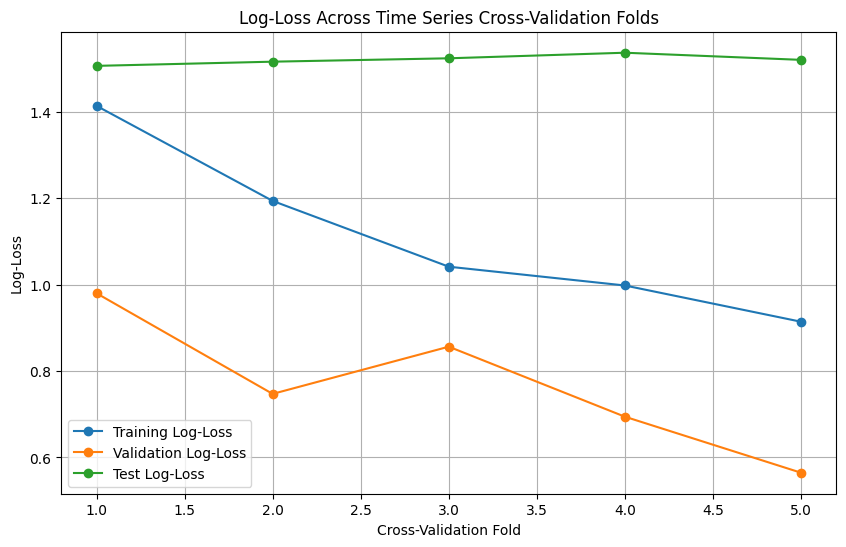

Final Log-Loss on Test Set: 1.5202
Final Accuracy on Test Set: 0.6141

Confusion Matrix:
[[ 83   0  10   7   0   3   1   3   0   0   2   0   1   0   0   0   0]
 [  0  98   0   0   0   0  10   0   1   0   1   0   0   0   0   0   0]
 [  0   0  38   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0 150   0   1   5   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  12   0   0   0   0   0   0   0   0   0   0   0   0]
 [  5   0   2   0   0  81   2   0   2   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  67   0   0   0   0   0   0   0   0   3   0]
 [  9   0   4   0   0   3   0  75   0   0   0   0   2   1   0   0   0]
 [  0   0   0   0   0   0   4   0  49   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  69   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  26   0   0   0   0   0]
 [  0   0   4   0   0   0   0   0   0   0   0   0  63   0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Step 1: Load the dataset
file_path = 'refined_candlestick_patterns1.csv'
candlestick_data = pd.read_csv(file_path)

# Step 2: Feature Engineering
# Calculate technical indicators: EMA, Bollinger Bands, MACD, and candlestick-specific features
candlestick_data['EMA_5'] = candlestick_data['Close'].ewm(span=5, adjust=False).mean()
candlestick_data['EMA_10'] = candlestick_data['Close'].ewm(span=10, adjust=False).mean()
candlestick_data['EMA_20'] = candlestick_data['Close'].ewm(span=20, adjust=False).mean()

candlestick_data['BB_Middle'] = candlestick_data['Close'].rolling(window=20).mean()
candlestick_data['BB_Upper'] = candlestick_data['BB_Middle'] + 2 * candlestick_data['Close'].rolling(window=20).std()
candlestick_data['BB_Lower'] = candlestick_data['BB_Middle'] - 2 * candlestick_data['Close'].rolling(window=20).std()

ema_12 = candlestick_data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = candlestick_data['Close'].ewm(span=26, adjust=False).mean()
candlestick_data['MACD'] = ema_12 - ema_26
candlestick_data['MACD_Signal'] = candlestick_data['MACD'].ewm(span=9, adjust=False).mean()

candlestick_data['Body_Size'] = abs(candlestick_data['Close'] - candlestick_data['Open'])
candlestick_data['Upper_Wick'] = candlestick_data['High'] - candlestick_data[['Open', 'Close']].max(axis=1)
candlestick_data['Lower_Wick'] = candlestick_data[['Open', 'Close']].min(axis=1) - candlestick_data['Low']
candlestick_data['Body_Wick_Ratio'] = candlestick_data['Body_Size'] / (candlestick_data['Upper_Wick'] + candlestick_data['Lower_Wick'] + 1e-6)

# Step 3: Create deeper sliding window features (10 candles back)
window_size = 10  # Deeper window
columns_to_shift = ['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_5', 'EMA_10', 'EMA_20', 'MACD', 'MACD_Signal']

for i in range(1, window_size):
    for col in columns_to_shift:
        candlestick_data[f'{col}_lag_{i}'] = candlestick_data[col].shift(i)

# Drop rows with NaN values generated during feature calculation
candlestick_data.dropna(inplace=True)

# Step 4: Encode categorical columns: 'Trend' and 'Candlestick Pattern'
label_encoder_trend = LabelEncoder()
candlestick_data['Trend'] = label_encoder_trend.fit_transform(candlestick_data['Trend'])

label_encoder_pattern = LabelEncoder()
candlestick_data['Candlestick Pattern'] = label_encoder_pattern.fit_transform(candlestick_data['Candlestick Pattern'])

# Step 5: Data Augmentation (Jittering and Scaling)
def augment_data(data, jitter_factor=0.01, scale_factor=0.05, n_augmentations=2):
    augmented_data = []
    for _ in range(n_augmentations):
        # Jitter: Add small random noise to OHLC values
        jittered_data = data.copy()
        jittered_data['Open'] *= (1 + jitter_factor * np.random.randn(len(data)))
        jittered_data['High'] *= (1 + jitter_factor * np.random.randn(len(data)))
        jittered_data['Low'] *= (1 + jitter_factor * np.random.randn(len(data)))
        jittered_data['Close'] *= (1 + jitter_factor * np.random.randn(len(data)))

        # Scaling: Slightly scale the entire pattern
        scaling_factor = 1 + scale_factor * np.random.randn()
        jittered_data[['Open', 'High', 'Low', 'Close']] *= scaling_factor

        augmented_data.append(jittered_data)

    # Combine original and augmented data
    augmented_data = pd.concat([data] + augmented_data, ignore_index=True)
    return augmented_data

# Apply data augmentation to the original dataset
augmented_candlestick_data = augment_data(candlestick_data, jitter_factor=0.01, scale_factor=0.05, n_augmentations=3)

# Step 6: Separate features and target variable
X = augmented_candlestick_data.drop(columns=['Start', 'End', 'Candlestick Pattern'])
y = augmented_candlestick_data['Candlestick Pattern']

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 8: Apply SMOTE with Tomek Links to handle class imbalance
smote_tomek = SMOTETomek(smote=SMOTE(k_neighbors=1), random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# Step 9: Initialize the RandomForestClassifier (without hyperparameter tuning)
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')

# Step 10: Cross-Validation for Log-Loss Tracking
log_losses_train = []
log_losses_val = []
log_losses_test = []

tscv = TimeSeriesSplit(n_splits=5)

for train_index, val_index in tscv.split(X_resampled):
    X_train_cv, X_val_cv = X_resampled[train_index], X_resampled[val_index]
    y_train_cv, y_val_cv = y_resampled[train_index], y_resampled[val_index]

    # Train the model
    rf_classifier.fit(X_train_cv, y_train_cv)

    # Predict probabilities for log-loss calculation (Training set)
    y_train_pred_prob = rf_classifier.predict_proba(X_train_cv)
    train_log_loss = log_loss(y_train_cv, y_train_pred_prob, labels=np.arange(len(label_encoder_pattern.classes_)))
    log_losses_train.append(train_log_loss)

    # Predict probabilities for log-loss calculation (Validation set)
    y_val_pred_prob = rf_classifier.predict_proba(X_val_cv)
    val_log_loss = log_loss(y_val_cv, y_val_pred_prob, labels=np.arange(len(label_encoder_pattern.classes_)))
    log_losses_val.append(val_log_loss)

    # Predict probabilities for log-loss calculation (Test set)
    y_test_pred_prob = rf_classifier.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_test_pred_prob, labels=np.arange(len(label_encoder_pattern.classes_)))
    log_losses_test.append(test_log_loss)

# Plot log-loss graph for training, validation, and test sets
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(log_losses_train) + 1), log_losses_train, marker='o', label='Training Log-Loss')
plt.plot(range(1, len(log_losses_val) + 1), log_losses_val, marker='o', label='Validation Log-Loss')
plt.plot(range(1, len(log_losses_test) + 1), log_losses_test, marker='o', label='Test Log-Loss')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('Log-Loss')
plt.title('Log-Loss Across Time Series Cross-Validation Folds')
plt.legend()
plt.grid(True)
plt.show()

# Step 11: Evaluate the tuned model on the test set
y_test_pred_prob = rf_classifier.predict_proba(X_test)
y_test_pred = rf_classifier.predict(X_test)

# Calculate log-loss and accuracy for the test set
final_log_loss = log_loss(y_test, y_test_pred_prob, labels=np.arange(len(label_encoder_pattern.classes_)))
final_accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=np.arange(len(label_encoder_pattern.classes_)))
classification_report_final = classification_report(y_test, y_test_pred, labels=np.arange(len(label_encoder_pattern.classes_)), target_names=label_encoder_pattern.classes_)

# Print results
print(f"Final Log-Loss on Test Set: {final_log_loss:.4f}")
print(f"Final Accuracy on Test Set: {final_accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report_final)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/usr/local/lib/python3.10

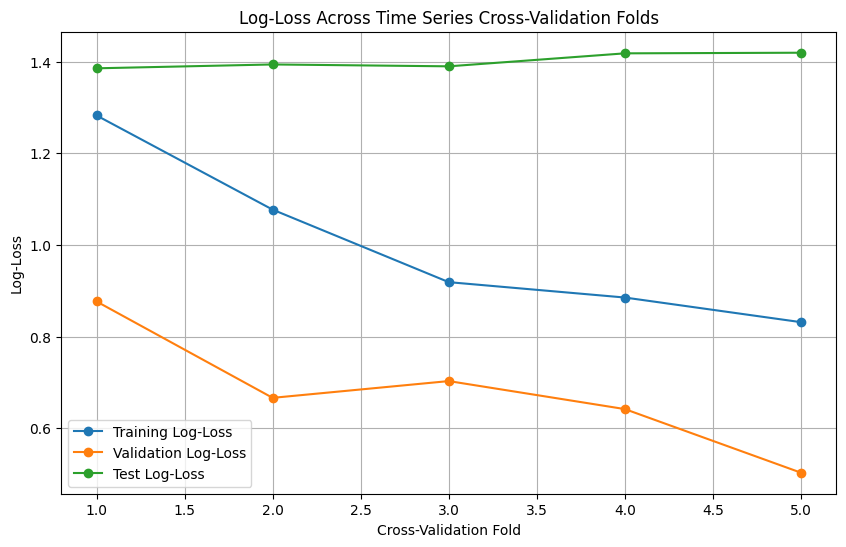

Final Log-Loss on Test Set: 1.4197
Final Accuracy on Test Set: 0.5925

Confusion Matrix:
[[ 84   0   9   4   0   6   1   3   0   0   2   0   1   0   0   0   0]
 [  0  98   0   0   0   0   7   1   1   0   3   0   0   0   0   0   0]
 [  0   0  38   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   4   0 148   0   1   3   0   0   0   0   0   1   0   0   0   0]
 [  0   0   0   0  12   0   0   0   0   0   0   0   0   0   0   0   0]
 [  6   1   4   0   0  78   1   0   2   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  64   0   4   0   2   0   0   0   0   0   0]
 [  5   0   0   0   0   3   0  84   0   0   0   0   2   0   0   0   0]
 [  0   0   0   0   0   0   0   0  53   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0]
 [  1   3   1   0   0   0   2   0   1   0  61   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  26   0   0   0   0   0]
 [  1   0   1   0   0   2   0   0   0   0   0   0  63   0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Step 1: Load the dataset
file_path = 'refined_candlestick_patterns1.csv'
candlestick_data = pd.read_csv(file_path)

# Step 2: Feature Engineering
# Calculate technical indicators: EMA, Bollinger Bands, MACD, and candlestick-specific features
candlestick_data['EMA_5'] = candlestick_data['Close'].ewm(span=5, adjust=False).mean()
candlestick_data['EMA_10'] = candlestick_data['Close'].ewm(span=10, adjust=False).mean()
candlestick_data['EMA_20'] = candlestick_data['Close'].ewm(span=20, adjust=False).mean()

candlestick_data['BB_Middle'] = candlestick_data['Close'].rolling(window=20).mean()
candlestick_data['BB_Upper'] = candlestick_data['BB_Middle'] + 2 * candlestick_data['Close'].rolling(window=20).std()
candlestick_data['BB_Lower'] = candlestick_data['BB_Middle'] - 2 * candlestick_data['Close'].rolling(window=20).std()

ema_12 = candlestick_data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = candlestick_data['Close'].ewm(span=26, adjust=False).mean()
candlestick_data['MACD'] = ema_12 - ema_26
candlestick_data['MACD_Signal'] = candlestick_data['MACD'].ewm(span=9, adjust=False).mean()

candlestick_data['Body_Size'] = abs(candlestick_data['Close'] - candlestick_data['Open'])
candlestick_data['Upper_Wick'] = candlestick_data['High'] - candlestick_data[['Open', 'Close']].max(axis=1)
candlestick_data['Lower_Wick'] = candlestick_data[['Open', 'Close']].min(axis=1) - candlestick_data['Low']
candlestick_data['Body_Wick_Ratio'] = candlestick_data['Body_Size'] / (candlestick_data['Upper_Wick'] + candlestick_data['Lower_Wick'] + 1e-6)

# Step 3: Create sliding window features
window_size = 3
columns_to_shift = ['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_5', 'EMA_10', 'EMA_20', 'MACD', 'MACD_Signal']
for i in range(1, window_size):
    for col in columns_to_shift:
        candlestick_data[f'{col}_lag_{i}'] = candlestick_data[col].shift(i)

# Drop rows with NaN values generated during feature calculation
candlestick_data.dropna(inplace=True)

# Step 4: Encode categorical columns: 'Trend' and 'Candlestick Pattern'
label_encoder_trend = LabelEncoder()
candlestick_data['Trend'] = label_encoder_trend.fit_transform(candlestick_data['Trend'])

label_encoder_pattern = LabelEncoder()
candlestick_data['Candlestick Pattern'] = label_encoder_pattern.fit_transform(candlestick_data['Candlestick Pattern'])

# Step 5: Data Augmentation (Jittering and Scaling)
def augment_data(data, jitter_factor=0.01, scale_factor=0.05, n_augmentations=2):
    augmented_data = []
    for _ in range(n_augmentations):
        # Jitter: Add small random noise to OHLC values
        jittered_data = data.copy()
        jittered_data['Open'] *= (1 + jitter_factor * np.random.randn(len(data)))
        jittered_data['High'] *= (1 + jitter_factor * np.random.randn(len(data)))
        jittered_data['Low'] *= (1 + jitter_factor * np.random.randn(len(data)))
        jittered_data['Close'] *= (1 + jitter_factor * np.random.randn(len(data)))

        # Scaling: Slightly scale the entire pattern
        scaling_factor = 1 + scale_factor * np.random.randn()
        jittered_data[['Open', 'High', 'Low', 'Close']] *= scaling_factor

        augmented_data.append(jittered_data)

    # Combine original and augmented data
    augmented_data = pd.concat([data] + augmented_data, ignore_index=True)
    return augmented_data

# Apply data augmentation to the original dataset
augmented_candlestick_data = augment_data(candlestick_data, jitter_factor=0.01, scale_factor=0.05, n_augmentations=3)

# Step 6: Separate features and target variable
X = augmented_candlestick_data.drop(columns=['Start', 'End', 'Candlestick Pattern'])
y = augmented_candlestick_data['Candlestick Pattern']

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 8: Apply SMOTE with Tomek Links to handle class imbalance
smote_tomek = SMOTETomek(smote=SMOTE(k_neighbors=1), random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# Step 9: Initialize the RandomForestClassifier (without hyperparameter tuning)
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')

# Step 10: Cross-Validation for Log-Loss Tracking
log_losses_train = []
log_losses_val = []
log_losses_test = []

tscv = TimeSeriesSplit(n_splits=5)

for train_index, val_index in tscv.split(X_resampled):
    X_train_cv, X_val_cv = X_resampled[train_index], X_resampled[val_index]
    y_train_cv, y_val_cv = y_resampled[train_index], y_resampled[val_index]

    # Train the model
    rf_classifier.fit(X_train_cv, y_train_cv)

    # Predict probabilities for log-loss calculation (Training set)
    y_train_pred_prob = rf_classifier.predict_proba(X_train_cv)
    train_log_loss = log_loss(y_train_cv, y_train_pred_prob, labels=np.arange(len(label_encoder_pattern.classes_)))
    log_losses_train.append(train_log_loss)

    # Predict probabilities for log-loss calculation (Validation set)
    y_val_pred_prob = rf_classifier.predict_proba(X_val_cv)
    val_log_loss = log_loss(y_val_cv, y_val_pred_prob, labels=np.arange(len(label_encoder_pattern.classes_)))
    log_losses_val.append(val_log_loss)

    # Predict probabilities for log-loss calculation (Test set)
    y_test_pred_prob = rf_classifier.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_test_pred_prob, labels=np.arange(len(label_encoder_pattern.classes_)))
    log_losses_test.append(test_log_loss)

# Plot log-loss graph for training, validation, and test sets
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(log_losses_train) + 1), log_losses_train, marker='o', label='Training Log-Loss')
plt.plot(range(1, len(log_losses_val) + 1), log_losses_val, marker='o', label='Validation Log-Loss')
plt.plot(range(1, len(log_losses_test) + 1), log_losses_test, marker='o', label='Test Log-Loss')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('Log-Loss')
plt.title('Log-Loss Across Time Series Cross-Validation Folds')
plt.legend()
plt.grid(True)
plt.show()

# Step 11: Evaluate the tuned model on the test set
y_test_pred_prob = rf_classifier.predict_proba(X_test)
y_test_pred = rf_classifier.predict(X_test)

# Calculate log-loss and accuracy for the test set
final_log_loss = log_loss(y_test, y_test_pred_prob, labels=np.arange(len(label_encoder_pattern.classes_)))
final_accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=np.arange(len(label_encoder_pattern.classes_)))
classification_report_final = classification_report(y_test, y_test_pred, labels=np.arange(len(label_encoder_pattern.classes_)), target_names=label_encoder_pattern.classes_)

# Print results
print(f"Final Log-Loss on Test Set: {final_log_loss:.4f}")
print(f"Final Accuracy on Test Set: {final_accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report_final)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/usr/local/lib/python3.10

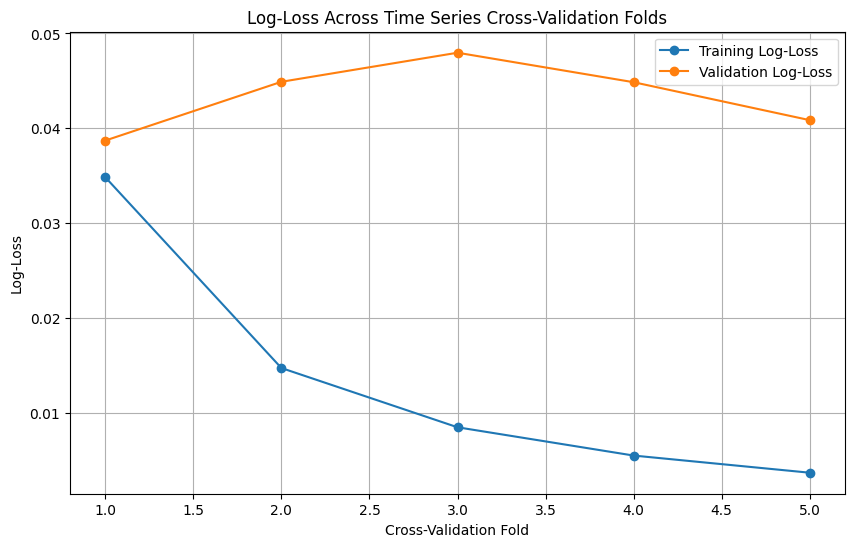

Final Log-Loss: 0.0830
Final Accuracy: 0.9921

Confusion Matrix:
[[106   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 110   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  38   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 153   0   0   0   0   0   0   0   0   0   0   0   0   4]
 [  0   0   0   0  12   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  92   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  70   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  90   0   0   0   0   0   0   0   0   4]
 [  0   0   0   0   0   0   0   0  54   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  69   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  26   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  67   0   0   0   0]
 [  0   0   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Step 1: Load the dataset
file_path = 'refined_candlestick_patterns1.csv'  # Replace with the actual path to your dataset
candlestick_data = pd.read_csv(file_path)

# Step 2: Feature Engineering
# Calculate technical indicators: EMA, Bollinger Bands, MACD, and candlestick-specific features
candlestick_data['EMA_5'] = candlestick_data['Close'].ewm(span=5, adjust=False).mean()
candlestick_data['EMA_10'] = candlestick_data['Close'].ewm(span=10, adjust=False).mean()
candlestick_data['EMA_20'] = candlestick_data['Close'].ewm(span=20, adjust=False).mean()

candlestick_data['BB_Middle'] = candlestick_data['Close'].rolling(window=20).mean()
candlestick_data['BB_Upper'] = candlestick_data['BB_Middle'] + 2 * candlestick_data['Close'].rolling(window=20).std()
candlestick_data['BB_Lower'] = candlestick_data['BB_Middle'] - 2 * candlestick_data['Close'].rolling(window=20).std()

ema_12 = candlestick_data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = candlestick_data['Close'].ewm(span=26, adjust=False).mean()
candlestick_data['MACD'] = ema_12 - ema_26
candlestick_data['MACD_Signal'] = candlestick_data['MACD'].ewm(span=9, adjust=False).mean()

candlestick_data['Body_Size'] = abs(candlestick_data['Close'] - candlestick_data['Open'])
candlestick_data['Upper_Wick'] = candlestick_data['High'] - candlestick_data[['Open', 'Close']].max(axis=1)
candlestick_data['Lower_Wick'] = candlestick_data[['Open', 'Close']].min(axis=1) - candlestick_data['Low']
candlestick_data['Body_Wick_Ratio'] = candlestick_data['Body_Size'] / (candlestick_data['Upper_Wick'] + candlestick_data['Lower_Wick'] + 1e-6)

# Step 3: Create sliding window features
window_size = 3
columns_to_shift = ['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_5', 'EMA_10', 'EMA_20', 'MACD', 'MACD_Signal']
for i in range(1, window_size):
    for col in columns_to_shift:
        candlestick_data[f'{col}_lag_{i}'] = candlestick_data[col].shift(i)

# Drop rows with NaN values generated during feature calculation
candlestick_data.dropna(inplace=True)

# Step 4: Encode categorical columns: 'Trend' and 'Candlestick Pattern'
label_encoder_trend = LabelEncoder()
candlestick_data['Trend'] = label_encoder_trend.fit_transform(candlestick_data['Trend'])

label_encoder_pattern = LabelEncoder()
candlestick_data['Candlestick Pattern'] = label_encoder_pattern.fit_transform(candlestick_data['Candlestick Pattern'])

# Step 5: Data Augmentation (Jittering and Scaling)
def augment_data(data, jitter_factor=0.01, scale_factor=0.05, n_augmentations=2):
    augmented_data = []
    for _ in range(n_augmentations):
        # Jitter: Add small random noise to OHLC values
        jittered_data = data.copy()
        jittered_data['Open'] *= (1 + jitter_factor * np.random.randn(len(data)))
        jittered_data['High'] *= (1 + jitter_factor * np.random.randn(len(data)))
        jittered_data['Low'] *= (1 + jitter_factor * np.random.randn(len(data)))
        jittered_data['Close'] *= (1 + jitter_factor * np.random.randn(len(data)))

        # Scaling: Slightly scale the entire pattern
        scaling_factor = 1 + scale_factor * np.random.randn()
        jittered_data[['Open', 'High', 'Low', 'Close']] *= scaling_factor

        augmented_data.append(jittered_data)

    # Combine original and augmented data
    augmented_data = pd.concat([data] + augmented_data, ignore_index=True)
    return augmented_data

# Apply data augmentation to the original dataset
augmented_candlestick_data = augment_data(candlestick_data, jitter_factor=0.01, scale_factor=0.05, n_augmentations=3)

# Step 6: Separate features and target variable
X = augmented_candlestick_data.drop(columns=['Start', 'End', 'Candlestick Pattern'])
y = augmented_candlestick_data['Candlestick Pattern']

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 8: Apply SMOTE with Tomek Links to handle class imbalance
smote_tomek = SMOTETomek(smote=SMOTE(k_neighbors=1), random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# Step 9: Initialize the Random Forest classifier with class weights
rf_classifier_smote_tomek = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Step 10: Use Time Series Cross-Validation (Expanding Window)
tscv = TimeSeriesSplit(n_splits=5)
log_losses_train = []
log_losses_val = []
accuracies = []
unique_classes = np.arange(len(label_encoder_pattern.classes_))  # Get the complete list of classes

# Perform cross-validation
for train_index, val_index in tscv.split(X_resampled):
    X_train_cv, X_val_cv = X_resampled[train_index], X_resampled[val_index]
    y_train_cv, y_val_cv = y_resampled[train_index], y_resampled[val_index]

    # Train the model
    rf_classifier_smote_tomek.fit(X_train_cv, y_train_cv)

    # Predict probabilities for log-loss calculation (Training set)
    y_train_pred_prob = rf_classifier_smote_tomek.predict_proba(X_train_cv)
    train_log_loss = log_loss(y_train_cv, y_train_pred_prob, labels=unique_classes)
    log_losses_train.append(train_log_loss)

    # Predict probabilities for log-loss calculation (Validation set)
    y_val_pred_prob = rf_classifier_smote_tomek.predict_proba(X_val_cv)
    val_log_loss = log_loss(y_val_cv, y_val_pred_prob, labels=unique_classes)
    log_losses_val.append(val_log_loss)

    # Calculate accuracy for the current fold
    y_val_pred = rf_classifier_smote_tomek.predict(X_val_cv)
    accuracies.append(accuracy_score(y_val_cv, y_val_pred))

# Plot log-loss graph for training and validation
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(log_losses_train) + 1), log_losses_train, marker='o', label='Training Log-Loss')
plt.plot(range(1, len(log_losses_val) + 1), log_losses_val, marker='o', label='Validation Log-Loss')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('Log-Loss')
plt.title('Log-Loss Across Time Series Cross-Validation Folds')
plt.legend()
plt.grid(True)
plt.show()

# Final evaluation on the test set after cross-validation
y_test_pred_prob = rf_classifier_smote_tomek.predict_proba(X_test)
y_test_pred = rf_classifier_smote_tomek.predict(X_test)

# Ensure log-loss calculation considers all classes
final_log_loss = log_loss(y_test, y_test_pred_prob, labels=unique_classes)

# Ensure accuracy and confusion matrix calculations use the complete set of classes
final_accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=unique_classes)
classification_report_final = classification_report(y_test, y_test_pred, labels=unique_classes, target_names=label_encoder_pattern.classes_)

# Print the final results in an organized way
print(f"Final Log-Loss: {final_log_loss:.4f}")
print(f"Final Accuracy: {final_accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report_final)


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Step 1: Load the dataset
file_path = 'refined_candlestick_patterns1.csv'
candlestick_data = pd.read_csv(file_path)

# Step 2: Feature Engineering
# Calculate technical indicators: EMA, Bollinger Bands, MACD, and candlestick-specific features
candlestick_data['EMA_5'] = candlestick_data['Close'].ewm(span=5, adjust=False).mean()
candlestick_data['EMA_10'] = candlestick_data['Close'].ewm(span=10, adjust=False).mean()
candlestick_data['EMA_20'] = candlestick_data['Close'].ewm(span=20, adjust=False).mean()

candlestick_data['BB_Middle'] = candlestick_data['Close'].rolling(window=20).mean()
candlestick_data['BB_Upper'] = candlestick_data['BB_Middle'] + 2 * candlestick_data['Close'].rolling(window=20).std()
candlestick_data['BB_Lower'] = candlestick_data['BB_Middle'] - 2 * candlestick_data['Close'].rolling(window=20).std()

ema_12 = candlestick_data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = candlestick_data['Close'].ewm(span=26, adjust=False).mean()
candlestick_data['MACD'] = ema_12 - ema_26
candlestick_data['MACD_Signal'] = candlestick_data['MACD'].ewm(span=9, adjust=False).mean()

candlestick_data['Body_Size'] = abs(candlestick_data['Close'] - candlestick_data['Open'])
candlestick_data['Upper_Wick'] = candlestick_data['High'] - candlestick_data[['Open', 'Close']].max(axis=1)
candlestick_data['Lower_Wick'] = candlestick_data[['Open', 'Close']].min(axis=1) - candlestick_data['Low']
candlestick_data['Body_Wick_Ratio'] = candlestick_data['Body_Size'] / (candlestick_data['Upper_Wick'] + candlestick_data['Lower_Wick'] + 1e-6)

# Step 3: Create sliding window features
window_size = 3
columns_to_shift = ['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_5', 'EMA_10', 'EMA_20', 'MACD', 'MACD_Signal']
for i in range(1, window_size):
    for col in columns_to_shift:
        candlestick_data[f'{col}_lag_{i}'] = candlestick_data[col].shift(i)

# Drop rows with NaN values generated during feature calculation
candlestick_data.dropna(inplace=True)

# Step 4: Encode categorical columns: 'Trend' and 'Candlestick Pattern'
label_encoder_trend = LabelEncoder()
candlestick_data['Trend'] = label_encoder_trend.fit_transform(candlestick_data['Trend'])

label_encoder_pattern = LabelEncoder()
candlestick_data['Candlestick Pattern'] = label_encoder_pattern.fit_transform(candlestick_data['Candlestick Pattern'])

# Step 5: Data Augmentation (Jittering and Scaling)
def augment_data(data, jitter_factor=0.01, scale_factor=0.05, n_augmentations=2):
    augmented_data = []
    for _ in range(n_augmentations):
        # Jitter: Add small random noise to OHLC values
        jittered_data = data.copy()
        jittered_data['Open'] *= (1 + jitter_factor * np.random.randn(len(data)))
        jittered_data['High'] *= (1 + jitter_factor * np.random.randn(len(data)))
        jittered_data['Low'] *= (1 + jitter_factor * np.random.randn(len(data)))
        jittered_data['Close'] *= (1 + jitter_factor * np.random.randn(len(data)))

        # Scaling: Slightly scale the entire pattern
        scaling_factor = 1 + scale_factor * np.random.randn()
        jittered_data[['Open', 'High', 'Low', 'Close']] *= scaling_factor

        augmented_data.append(jittered_data)

    # Combine original and augmented data
    augmented_data = pd.concat([data] + augmented_data, ignore_index=True)
    return augmented_data

# Apply data augmentation to the original dataset
augmented_candlestick_data = augment_data(candlestick_data, jitter_factor=0.01, scale_factor=0.05, n_augmentations=3)

# Step 6: Separate features and target variable
X = augmented_candlestick_data.drop(columns=['Start', 'End', 'Candlestick Pattern'])
y = augmented_candlestick_data['Candlestick Pattern']

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 8: Apply SMOTE with Tomek Links to handle class imbalance
smote_tomek = SMOTETomek(smote=SMOTE(k_neighbors=1), random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# Step 9: Hyperparameter Tuning with GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

# Set up GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=tscv, scoring='neg_log_loss', n_jobs=-1)

# Fit the grid search to the resampled training data
grid_search.fit(X_resampled, y_resampled)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

# Step 10: Train the Random Forest with the best parameters on the entire training set
rf_best = RandomForestClassifier(**grid_search.best_params_, random_state=42, class_weight='balanced')
rf_best.fit(X_resampled, y_resampled)

# Step 11: Cross-Validation for Log-Loss Tracking
log_losses_train = []
log_losses_val = []

for train_index, val_index in tscv.split(X_resampled):
    X_train_cv, X_val_cv = X_resampled[train_index], X_resampled[val_index]
    y_train_cv, y_val_cv = y_resampled[train_index], y_resampled[val_index]

    # Train the model
    rf_best.fit(X_train_cv, y_train_cv)

    # Predict probabilities for log-loss calculation (Training set)
    y_train_pred_prob = rf_best.predict_proba(X_train_cv)
    train_log_loss = log_loss(y_train_cv, y_train_pred_prob, labels=np.arange(len(label_encoder_pattern.classes_)))
    log_losses_train.append(train_log_loss)

    # Predict probabilities for log-loss calculation (Validation set)
    y_val_pred_prob = rf_best.predict_proba(X_val_cv)
    val_log_loss = log_loss(y_val_cv, y_val_pred_prob, labels=np.arange(len(label_encoder_pattern.classes_)))
    log_losses_val.append(val_log_loss)

# Plot log-loss graph for training and validation
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(log_losses_train) + 1), log_losses_train, marker='o', label='Training Log-Loss')
plt.plot(range(1, len(log_losses_val) + 1), log_losses_val, marker='o', label='Validation Log-Loss')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('Log-Loss')
plt.title('Log-Loss Across Time Series Cross-Validation Folds')
plt.legend()
plt.grid(True)
plt.show()

# Step 12: Evaluate the tuned model on the test set
y_test_pred_prob = rf_best.predict_proba(X_test)
y_test_pred = rf_best.predict(X_test)

# Calculate log-loss and accuracy for the test set
final_log_loss = log_loss(y_test, y_test_pred_prob, labels=np.arange(len(label_encoder_pattern.classes_)))
final_accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=np.arange(len(label_encoder_pattern.classes_)))
classification_report_final = classification_report(y_test, y_test_pred, labels=np.arange(len(label_encoder_pattern.classes_)), target_names=label_encoder_pattern.classes_)

# Print results
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Log-Loss: {best_score:.4f}")
print(f"Final Log-Loss on Test Set: {final_log_loss:.4f}")
print(f"Final Accuracy on Test Set: {final_accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report_final)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py"

InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Step 1: Load the dataset
file_path = 'refined_candlestick_patterns1.csv'
candlestick_data = pd.read_csv(file_path)

# Step 2: Feature Engineering
# Calculate technical indicators: EMA, Bollinger Bands, MACD, and candlestick-specific features
candlestick_data['EMA_5'] = candlestick_data['Close'].ewm(span=5, adjust=False).mean()
candlestick_data['EMA_10'] = candlestick_data['Close'].ewm(span=10, adjust=False).mean()
candlestick_data['EMA_20'] = candlestick_data['Close'].ewm(span=20, adjust=False).mean()

candlestick_data['BB_Middle'] = candlestick_data['Close'].rolling(window=20).mean()
candlestick_data['BB_Upper'] = candlestick_data['BB_Middle'] + 2 * candlestick_data['Close'].rolling(window=20).std()
candlestick_data['BB_Lower'] = candlestick_data['BB_Middle'] - 2 * candlestick_data['Close'].rolling(window=20).std()

ema_12 = candlestick_data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = candlestick_data['Close'].ewm(span=26, adjust=False).mean()
candlestick_data['MACD'] = ema_12 - ema_26
candlestick_data['MACD_Signal'] = candlestick_data['MACD'].ewm(span=9, adjust=False).mean()

candlestick_data['Body_Size'] = abs(candlestick_data['Close'] - candlestick_data['Open'])
candlestick_data['Upper_Wick'] = candlestick_data['High'] - candlestick_data[['Open', 'Close']].max(axis=1)
candlestick_data['Lower_Wick'] = candlestick_data[['Open', 'Close']].min(axis=1) - candlestick_data['Low']
candlestick_data['Body_Wick_Ratio'] = candlestick_data['Body_Size'] / (candlestick_data['Upper_Wick'] + candlestick_data['Lower_Wick'] + 1e-6)

# Step 3: Create sliding window features
window_size = 3
columns_to_shift = ['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_5', 'EMA_10', 'EMA_20', 'MACD', 'MACD_Signal']
for i in range(1, window_size):
    for col in columns_to_shift:
        candlestick_data[f'{col}_lag_{i}'] = candlestick_data[col].shift(i)

# Drop rows with NaN values generated during feature calculation
candlestick_data.dropna(inplace=True)

# Step 4: Encode categorical columns: 'Trend' and 'Candlestick Pattern'
label_encoder_trend = LabelEncoder()
candlestick_data['Trend'] = label_encoder_trend.fit_transform(candlestick_data['Trend'])

label_encoder_pattern = LabelEncoder()
candlestick_data['Candlestick Pattern'] = label_encoder_pattern.fit_transform(candlestick_data['Candlestick Pattern'])

# Step 5: Data Augmentation (Jittering and Scaling)
def augment_data(data, jitter_factor=0.01, scale_factor=0.05, n_augmentations=2):
    augmented_data = []
    for _ in range(n_augmentations):
        # Jitter: Add small random noise to OHLC values
        jittered_data = data.copy()
        jittered_data['Open'] *= (1 + jitter_factor * np.random.randn(len(data)))
        jittered_data['High'] *= (1 + jitter_factor * np.random.randn(len(data)))
        jittered_data['Low'] *= (1 + jitter_factor * np.random.randn(len(data)))
        jittered_data['Close'] *= (1 + jitter_factor * np.random.randn(len(data)))

        # Scaling: Slightly scale the entire pattern
        scaling_factor = 1 + scale_factor * np.random.randn()
        jittered_data[['Open', 'High', 'Low', 'Close']] *= scaling_factor

        augmented_data.append(jittered_data)

    # Combine original and augmented data
    augmented_data = pd.concat([data] + augmented_data, ignore_index=True)
    return augmented_data

# Apply data augmentation to the original dataset
augmented_candlestick_data = augment_data(candlestick_data, jitter_factor=0.01, scale_factor=0.05, n_augmentations=3)

# Step 6: Separate features and target variable
X = augmented_candlestick_data.drop(columns=['Start', 'End', 'Candlestick Pattern'])
y = augmented_candlestick_data['Candlestick Pattern']

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 8: Apply SMOTE with Tomek Links to handle class imbalance
smote_tomek = SMOTETomek(smote=SMOTE(k_neighbors=1), random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# Step 9: Hyperparameter Tuning with GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

# Set up GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=tscv, scoring='neg_log_loss', n_jobs=-1)

# Fit the grid search to the resampled training data
grid_search.fit(X_resampled, y_resampled)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

# Step 10: Train the Random Forest with the best parameters on the entire training set
rf_best = RandomForestClassifier(**grid_search.best_params_, random_state=42, class_weight='balanced')
rf_best.fit(X_resampled, y_resampled)

# Step 11: Evaluate the tuned model on the test set
y_test_pred_prob = rf_best.predict_proba(X_test)
y_test_pred = rf_best.predict(X_test)

# Calculate log-loss and accuracy for the test set
final_log_loss = log_loss(y_test, y_test_pred_prob, labels=np.arange(len(label_encoder_pattern.classes_)))
final_accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=np.arange(len(label_encoder_pattern.classes_)))
classification_report_final = classification_report(y_test, y_test_pred, labels=np.arange(len(label_encoder_pattern.classes_)), target_names=label_encoder_pattern.classes_)

# Print results
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Log-Loss: {best_score:.4f}")
print(f"Final Log-Loss on Test Set: {final_log_loss:.4f}")
print(f"Final Accuracy on Test Set: {final_accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report_final)


In [ ]:
# Calculate additional technical indicators for feature enhancement

# Exponential Moving Averages (EMA) for different periods
candlestick_data['EMA_5'] = candlestick_data['Close'].ewm(span=5, adjust=False).mean()
candlestick_data['EMA_10'] = candlestick_data['Close'].ewm(span=10, adjust=False).mean()
candlestick_data['EMA_20'] = candlestick_data['Close'].ewm(span=20, adjust=False).mean()

# Bollinger Bands (20-period)
candlestick_data['BB_Middle'] = candlestick_data['Close'].rolling(window=20).mean()
candlestick_data['BB_Upper'] = candlestick_data['BB_Middle'] + 2 * candlestick_data['Close'].rolling(window=20).std()
candlestick_data['BB_Lower'] = candlestick_data['BB_Middle'] - 2 * candlestick_data['Close'].rolling(window=20).std()

# Moving Average Convergence Divergence (MACD)
ema_12 = candlestick_data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = candlestick_data['Close'].ewm(span=26, adjust=False).mean()
candlestick_data['MACD'] = ema_12 - ema_26
candlestick_data['MACD_Signal'] = candlestick_data['MACD'].ewm(span=9, adjust=False).mean()

# Candlestick-specific features: body size, upper wick, and lower wick
candlestick_data['Body_Size'] = abs(candlestick_data['Close'] - candlestick_data['Open'])
candlestick_data['Upper_Wick'] = candlestick_data['High'] - candlestick_data[['Open', 'Close']].max(axis=1)
candlestick_data['Lower_Wick'] = candlestick_data[['Open', 'Close']].min(axis=1) - candlestick_data['Low']
candlestick_data['Body_Wick_Ratio'] = candlestick_data['Body_Size'] / (candlestick_data['Upper_Wick'] + candlestick_data['Lower_Wick'] + 1e-6)

# Drop rows with NaN values generated during feature calculation
candlestick_data.dropna(inplace=True)

# Separate features and target variable
X = candlestick_data.drop(columns=['Start', 'End', 'Candlestick Pattern'])
y = candlestick_data['Candlestick Pattern']

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train the Random Forest model on the enhanced dataset
rf_classifier_enhanced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_enhanced.fit(X_train, y_train)

# Predict on the test set
y_pred_enhanced = rf_classifier_enhanced.predict(X_test)

# Evaluate the model
accuracy_enhanced = accuracy_score(y_test, y_pred_enhanced)
classification_report_enhanced = classification_report(y_test, y_pred_enhanced, target_names=label_encoder_pattern.classes_)

accuracy_enhanced, classification_report_enhanced


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5643564356435643,
 '                      precision    recall  f1-score   support\n\n   BEARISH ENGULFING       0.00      0.00      0.00        27\n   BULLISH ENGULFING       0.33      0.11      0.17        27\n    DARK CLOUD COVER       0.50      0.11      0.18         9\n                DOJI       0.72      0.67      0.69        39\n   EVENING DOJI STAR       0.00      0.00      0.00         3\n        EVENING STAR       0.80      0.17      0.29        23\n              HAMMER       0.67      0.24      0.35        17\n         HANGING MAN       0.25      0.04      0.07        23\n     INVERTED HAMMER       0.00      0.00      0.00        14\n   MORNING DOJI STAR       0.00      0.00      0.00         1\n        MORNING STAR       0.33      0.06      0.10        17\n       PIERCING LINE       0.00      0.00      0.00         7\n       SHOOTING STAR       0.00      0.00      0.00        16\n        SPINNING TOP       0.57      0.70      0.63        81\n   THREE BLACK CROWS       0.0

In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.metrics import log_loss, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Initialize SMOTE with Tomek Links and adjust n_neighbors
smote_tomek = SMOTETomek(smote=SMOTE(n_neighbors=1), random_state=42)

# Apply SMOTE with Tomek Links to the training set
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# Initialize the Random Forest classifier with class weights
rf_classifier_smote_tomek = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Use Time Series Cross-Validation (Expanding Window)
tscv = TimeSeriesSplit(n_splits=5)
log_losses = []
accuracies = []

# Perform cross-validation
for train_index, val_index in tscv.split(X_resampled):
    X_train_cv, X_val_cv = X_resampled[train_index], X_resampled[val_index]
    y_train_cv, y_val_cv = y_resampled[train_index], y_resampled[val_index]

    # Train the model
    rf_classifier_smote_tomek.fit(X_train_cv, y_train_cv)

    # Predict probabilities for log-loss calculation
    y_val_pred_prob = rf_classifier_smote_tomek.predict_proba(X_val_cv)
    y_val_pred = rf_classifier_smote_tomek.predict(X_val_cv)

    # Calculate log-loss and accuracy for the current fold
    log_losses.append(log_loss(y_val_cv, y_val_pred_prob))
    accuracies.append(accuracy_score(y_val_cv, y_val_pred))

# Plot log-loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(log_losses) + 1), log_losses, marker='o', label='Log-Loss (Cross-Validation)')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('Log-Loss')
plt.title('Log-Loss Across Time Series Cross-Validation Folds')
plt.legend()
plt.grid(True)
plt.show()

# Final evaluation on the test set after cross-validation
y_test_pred_prob = rf_classifier_smote_tomek.predict_proba(X_test)
y_test_pred = rf_classifier_smote_tomek.predict(X_test)
final_log_loss = log_loss(y_test, y_test_pred_prob)
final_accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)
classification_report_final = classification_report(y_test, y_test_pred, target_names=label_encoder_pattern.classes_)

final_log_loss, final_accuracy, conf_matrix, classification_report_final


TypeError: SMOTE.__init__() got an unexpected keyword argument 'n_neighbors'